# About NLP and NLTK

> NLP is important for scientific, economic, social, and cultural reasons. NLP is experiencing rapid growth as its theories and methods are deployed in a variety of new language technologies. For this reason it is important for a wide range of people to have a working knowledge of NLP. Within industry, this includes people in human-computer interaction, business information analysis, and web software development. Within academia, it includes people in areas from humanities computing and corpus linguistics through to computer science and artificial intelligence.
>
> NLTK was originally created in 2001 as part of a computational linguistics course in the Department of Computer and Information Science at the University of Pennsylvania. Since then it has been developed and expanded with the help of dozens of contributors. It has now been adopted in courses in dozens of universities, and serves as the basis of many research projects.

_Source: [https://www.nltk.org/book/](https://www.nltk.org/book/)_

NLTK was designed with four primary goals in mind:

- **Simplicity**: To provide an intuitive framework along with substantial building blocks, giving users a practical knowledge of NLP without getting bogged down in the tedious house-keeping usually associated with processing annotated language data.
- **Consistency**: To provide a uniform framework with consistent interfaces and data structures, and easily-guessable method names.
- **Extensibility**: To provide a structure into which new software modules can be easily accommodated, including alternative implementations and competing approaches to the same task.
- **Modularity**: To provide components that can be used independently without needing to understand the rest of the toolkit.

Language processing tasks and corresponding NLTK modules with examples of functionality:

| Task | NLTK Module(s)	| Functionality |
| :-: | :-: | :-: |
|Accessing corpora|corpus|standardized interfaces to corpora and lexicons|
|String processing|tokenize, stem|tokenizers, sentence tokenizers, stemmers|
|Collocation discovery|collocations|t-test, chi-squared, point-wise mutual information|
|Part-of-speech tagging|tag	|n-gram, backoff, Brill, HMM, TnT|
|Machine learning|classify, cluster, tbl|decision tree, maximum entropy, naive Bayes, EM, k-means|
|Chunking|chunk|regular expression, n-gram, named-entity|
|Parsing|parse, ccg|chart, feature-based, unification, probabilistic, dependency|
|Semantic interpretation|sem, inference|lambda calculus, first-order logic, model checking|
|Evaluation metrics|metrics|precision, recall, agreement coefficients|
|Probability and estimation|probability|frequency distributions, smoothed probability distributions|
|Applications|app, chat|graphical concordancer, parsers, WordNet browser, chatbots|
|Linguistic|fieldwork|toolbox	manipulate data in SIL Toolbox format|

# Dependencies

In [1]:
%matplotlib inline
import re
import nltk
import string
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
# nltk.download(['twitter_samples', 'stopwords'])

In [3]:
from colorama import init, Fore, Style
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import twitter_samples, stopwords

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Data Exploration

As the Twiiter dataset is already split into two files based on whether they imply a positive sentiment or not, we import them individually.

In [5]:
positive_twts = twitter_samples.strings('positive_tweets.json')
negative_twts = twitter_samples.strings('negative_tweets.json')

We take a quick look at the size of the dataset and it's general distribution. We can note that it is a balanced dataset.

In [6]:
print(Fore.GREEN + 'Positive Tweets: ' + str(len(positive_twts)))
print(Fore.RED + 'Negative Tweets: ' + str(len(negative_twts)))

Positive Tweets: 5000
Negative Tweets: 5000


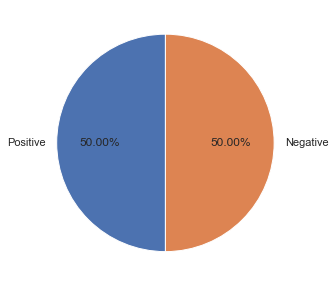

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(
    [len(positive_twts), len(negative_twts)],
    labels=['Positive', 'Negative'],
    autopct='%2.2f%%',
    startangle=90
)
plt.show()

We also take a look at two random tweets in the dataset that correspond to the two sentiments.

In [8]:
print(Fore.GREEN + positive_twts[random.randint(0, 5000)])
print(Fore.RED + negative_twts[random.randint(0, 5000)])

@MikeDuffy_20 Thanks - nice to finally see the end of the works (nearly...) :)
@LivingLifeNottm @honestmumma @moderndadpages I'm not looking forward to ours, mine goes next year at 3 :(


# Data Pre-processing and Feature Extraction

Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words.

In [9]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Punctuations do not add meaning to the textual data in this context, we can safely remove them.

In [10]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


We define a function that cleans a tweet by removing RTs, @mentions, URLs and hashes in the hashtags. Furthermore, we undertake tokenization and stemming of the words.

In [11]:
def process_tweet(tweet):
    """
    Preproceeses a Tweet by removing hashes, RTs, @mentions,
    links, stopwords and punctuation, tokenizing and stemming 
    the words.
    
    Accepts:
        tweet {str} -- tweet string
    
    Returns:
        {list<str>}
    """
    
    proc_twt = re.sub(r'^RT[\s]+', '', tweet)
    proc_twt = re.sub(r'@[\w_-]+', '', proc_twt)
    proc_twt = re.sub(r'#', '', proc_twt)
    proc_twt = re.sub(r'https?:\/\/.*[\r\n]*', '', proc_twt)
    tokenizer = TweetTokenizer(
        preserve_case=False, 
        strip_handles=True,
        reduce_len=True
    )
    
    twt_clean = []
    twt_tokens = tokenizer.tokenize(proc_twt)
    stopwords_en = stopwords.words('english')
    for word in twt_tokens:
        if word not in stopwords_en and word not in string.punctuation:
            twt_clean.append(word)
            
    twt_stems = []
    stemmer = PorterStemmer()
    for word in twt_clean:
        twt_stems.append(stemmer.stem(word))
        
    return twt_stems

We define a function that returns the frequency mapping for each word for each tweet in a set of tweets and the two sentiment classes.

In [12]:
def build_freqs(tweets, labels):
    """
    Builds frequencies for a set of twwets and
    matching labels or sentiments
    
    Accepts:
        tweets {list<str>} -- tweets in the dataset
        labels {float} -- label (0. = -ve; 1. = +ve)
    
    Returns:
        {list<float>}
    """
        
    labels = np.squeeze(labels).tolist()

    freqs = {}
    for (tweet, label) in zip(tweets, labels):
        for word in process_tweet(tweet):
            if (word, label) in freqs:
                freqs[(word, label)] += 1
            else:
                freqs[(word, label)] = 1
                
    return freqs

We build the labels vector for the dataset as we already know that the datasets have been split on the basis of the sentiment. Then we build the frequency mapping for a certain word and a sentiment.

In [13]:
labels = np.append(
    np.ones(len(positive_twts)),
    np.zeros(len(negative_twts))
)
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [14]:
freqs = build_freqs(positive_twts + negative_twts, labels)

# Validation of Processed Data

We cherrypick some stems and emojis and construct a n x 3 dimensional matrix to represent the positive and negative frequencies for each stem and emoji.

In [15]:
keys = [
    'happi', 'merri', 'nice', 'good', 
    'bad','sad', 'mad', 'best', 'pretti',
    '❤', ':)', ':(', '😒', '😬', '😄',
    '😍', '♛', 'song', 'idea', 'power', 
    'play', 'magnific', 'grind', 'bruise'
]

data = []

for word in keys:
    pos_freq = neg_freq = 0
    if (word, 1) in freqs:
        pos_freq = freqs[(word, 1)]
    if (word, 0) in freqs:
        neg_freq = freqs[(word, 0)]
    data.append([word, pos_freq, neg_freq])
    
data

[['happi', 211, 25],
 ['merri', 1, 0],
 ['nice', 98, 19],
 ['good', 238, 101],
 ['bad', 18, 73],
 ['sad', 5, 123],
 ['mad', 4, 11],
 ['best', 65, 22],
 ['pretti', 20, 15],
 ['❤', 29, 21],
 [':)', 3568, 2],
 [':(', 1, 4571],
 ['😒', 1, 3],
 ['😬', 0, 2],
 ['😄', 5, 1],
 ['😍', 2, 1],
 ['♛', 0, 210],
 ['song', 22, 27],
 ['idea', 26, 10],
 ['power', 7, 6],
 ['play', 46, 48],
 ['magnific', 2, 0],
 ['grind', 1, 1],
 ['bruise', 0, 0]]

We visualize the aforementioned matrix on a scatter plot. We draw a line to mark a rough decision boundary. We see that data points on the left of the boundary have negative sentiment and those on the right have positive sentiment.

/usr/lib/python3.9/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 10084 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/usr/lib/python3.9/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 128530 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/usr/lib/python3.9/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 128556 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/usr/lib/python3.9/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 128516 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/usr/lib/python3.9/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 128525 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/usr/lib/python3.9/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 9819 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/usr/lib/python3.9/site-p

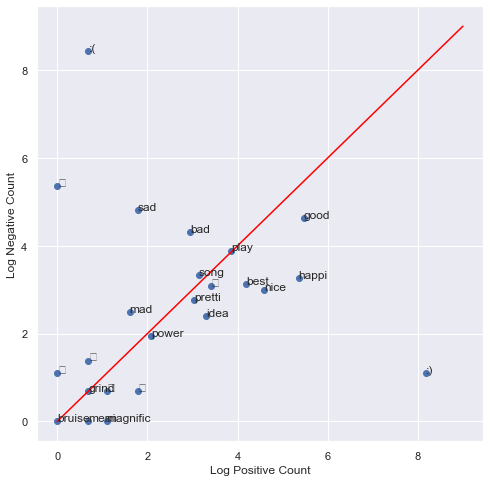

In [16]:
fig, ax = plt.subplots(figsize = (8, 8))

x = np.log([x[1] + 1 for x in data])  
y = np.log([x[2] + 1 for x in data]) 

ax.scatter(x, y)  

plt.xlabel("Log Positive Count")
plt.ylabel("Log Negative Count")

for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color='red')

plt.show()

# Feature Extraction

For each tweet, we can compute positive and negative class frequencies for each word in that tweet. In this case, we are considering the sum of positive and negative frequencies as the feature vector for each tweet.

In [17]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1, 2)
    '''
    word_l = process_tweet(tweet)
    x = np.zeros((1, 2)) 
    for word in word_l:
        x[0, 0] += freqs.get((word, 1), 0)
        x[0, 1] += freqs.get((word, 0), 0)
    assert(x.shape == (1, 2))
    return x

In [18]:
extract_features('This is a sample tweet in which I am happy :)', freqs)

array([[3840.,   63.]])

# Train Test Split

In [19]:
x_train_pos, x_test_pos, y_train_pos, y_test_pos = train_test_split(
    positive_twts, labels[:5000],
    test_size=0.2, random_state=42
)

In [20]:
x_train_neg, x_test_neg, y_train_neg, y_test_neg = train_test_split(
    negative_twts, labels[5000:],
    test_size=0.2, random_state=42
)

In [21]:
x_train = x_train_pos + x_train_neg
y_train = np.append(np.ones(len(x_train_pos)), np.zeros(len(x_train_neg)))

In [22]:
x_test = x_test_pos + x_test_neg
y_test = np.append(np.ones(len(x_test_pos)), np.zeros(len(x_test_neg)))

In [23]:
print(Fore.GREEN + 'Length of training set: ', str(len(x_train)))
print(Fore.RED + 'Length of testing set: ' + str(len(x_test)))

Length of training set:  8000
Length of testing set: 2000


In [24]:
print(Fore.GREEN + 'Shape of training set labels: ', str(y_train.shape))
print(Fore.RED + 'Shape of testing set labels: ' + str(y_test.shape))

Shape of training set labels:  (8000,)
Shape of testing set labels: (2000,)


# Dataset Overview

## Training Dataset

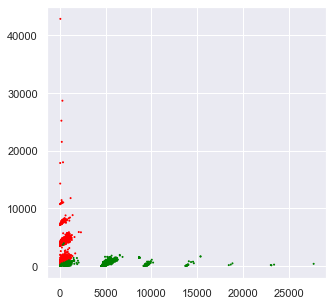

In [25]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(
    np.array([extract_features(x, freqs)[0] for x in x_train])[:, 1],
    np.array([extract_features(x, freqs)[0] for x in x_train])[:, 0],
    c=[['green', 'red'][int(y)] for y in y_train],
    s=1
)
plt.show()

## Testing Dataset

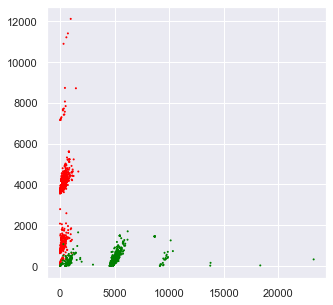

In [26]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(
    np.array([extract_features(x, freqs)[0] for x in x_test])[:, 1],
    np.array([extract_features(x, freqs)[0] for x in x_test])[:, 0],
    c=[['green', 'red'][int(y)] for y in y_test],
    s=1
)
plt.show()

# Logistic Regression Classifier

In logistic regression, we have the sigmoid function for the prediction which maps the input logits $z$ to a value that ranges between 0 and 1, and so it can be treated as a probability. It applies the sigmoid to the output of the linear regression logits.

$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

$$ h(z) = \frac{1}{1+\exp^{-z}}$$

The cost function used for logistic regression is the average of the log loss across $m$ training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))$$

In order to optimise the model and find the optimum parameter vector $\theta$, we implement gradient descent.

$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \frac{\partial J(\theta)}{\partial \theta}$$

In [27]:
x_lr_train = np.array([extract_features(x, freqs)[0] for x in x_train])
y_lr_train = y_train

x_lr_test = np.array([extract_features(x, freqs)[0] for x in x_test])
y_lr_test = y_test

In [28]:
from sklearn.linear_model import SGDClassifier

logRegModel = SGDClassifier(loss='log')
logRegModel.fit(x_lr_train, y_lr_train)

y_lr_pred = logRegModel.predict(x_lr_test)

Confusion Matrix:


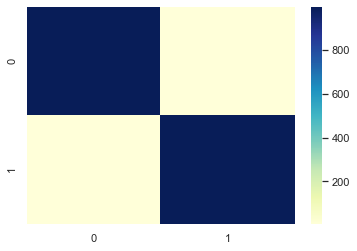

In [29]:
print('Confusion Matrix:')
sns.heatmap(confusion_matrix(y_test, y_lr_pred), cmap='YlGnBu')
plt.show()

In [30]:
print('Classification Report:')
print(classification_report(y_test, y_lr_pred, target_names=['-ve', '+ve']))

Classification Report:
              precision    recall  f1-score   support

         -ve       0.99      0.99      0.99      1000
         +ve       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [31]:
acc_logReg = accuracy_score(y_test, y_lr_pred) * 100
print(f'Accuracy: {acc_logReg:2.2f}%')

Accuracy: 99.35%


# Naive Bayes Classifier

According to Bayes' theorem,

![](https://www.saedsayad.com/images/Bayes_rule.png "")

Naive Bayes is an algorithm that can also be used for sentiment analysis. $P(D_{pos})$ is the probability that the document is positive. $P(D_{neg})$ is the probability that the document is negative. Here, $D$ is the total number of documents, or tweets in this case, $D_{pos}$ is the total number of positive tweets and $D_{neg}$ is the total number of negative tweets.

$$P(D_{pos}) = \frac{D_{pos}}{D}$$

$$P(D_{neg}) = \frac{D_{neg}}{D}$$

According to the Naive Bayes algorithm,

$$p = \frac{P(pos)}{P(neg)} \prod_{i=1}^{m} \frac{P(word_i | pos)}{P(word_i | neg)}\$$

To compute the positive and negative probability for a specific word using these formulae:

$$ P(pos) = \frac{freq_{pos} + 1}{N_{pos} +|V|}$$

$$ P(neg) = \frac{freq_{neg} + 1}{N_{neg} +|V|}$$

Here, $1$ is added to the numerator to account for words having zero probabilities and $|V|$, the size of the vocabulary is added to the denominator to account for the $1$ in the numerator. This is Laplacian or Additive Smoothing. 

The term $\frac{P(pos)}{P(neg)}$ can lead to underflow, therefore, $\log \frac{P(pos)}{P(neg)} = \log{P(pos)} - \log{P(neg)}$ is calculated and is known as the $\log$ prior.

To compute the $\log$ likelihood, i.e., the ratio of the probabilities of a word being in one of the classes of that very same word, we can implement the following equation which will result in a value within $[0, \infty)$:

$$\log \text{likelihood} = \log \left(\frac{P(W_{pos})}{P(W_{neg})} \right)$$

A $\log$ likelihood of $1$ shall mean that the word is neutral, a value $>1$ means that the word is positive and negative otherwise.

Now, we sum the $\log$ prior and the $\log$ likelihood to get $p$.

The evaluation is done by computing the following metric:

$$J = \frac{1}{m} \sum_{i=1}^n pred_i = y$$

In [32]:
x_nb_train = np.array([extract_features(x, freqs)[0] for x in x_train])
y_nb_train = y_train

x_nb_test = np.array([extract_features(x, freqs)[0] for x in x_test])
y_nb_test = y_test

In [33]:
from sklearn.naive_bayes import CategoricalNB

nbModel = CategoricalNB()
nbModel.fit(x_nb_train, y_nb_train)

y_nb_pred = nbModel.predict(x_nb_test)

Confusion Matrix:


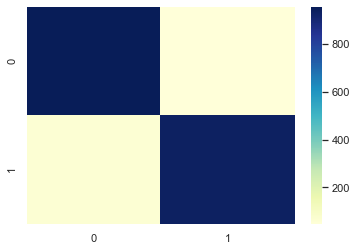

In [34]:
print('Confusion Matrix:')
sns.heatmap(confusion_matrix(y_test, y_nb_pred), cmap='YlGnBu')
plt.show()

In [35]:
print('Classification Report:')
print(classification_report(y_test, y_nb_pred, target_names=['-ve', '+ve']))

Classification Report:
              precision    recall  f1-score   support

         -ve       0.94      0.95      0.95      1000
         +ve       0.95      0.94      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.95      0.95      0.94      2000
weighted avg       0.95      0.94      0.94      2000



In [36]:
acc_nb = accuracy_score(y_test, y_nb_pred) * 100
print(f'Accuracy: {acc_nb:2.2f}%')

Accuracy: 94.50%


# KNN Classifier

The k-nearest neighbors (KNN) algorithm is a simple, easy-to-implement supervised machine learning algorithm that can be used to solve both classification and regression problems. KNN captures the idea of similarity (sometimes called distance, proximity, or closeness) between word vectors in this case.

We can compute the similarity between two vectors using the Euclidean distance. Euclidean distance is defined as:

$$ \begin{aligned} d(\mathbf{A}, \mathbf{B})=d(\mathbf{B}, \mathbf{A}) &=\sqrt{\left(A_{1}-B_{1}\right)^{2}+\left(A_{2}-B_{2}\right)^{2}+\cdots+\left(A_{n}-B_{n}\right)^{2}} \\ &=\sqrt{\sum_{i=1}^{n}\left(A_{i}-B_{i}\right)^{2}} \end{aligned}$$


Cosine similarity, based on the intuition that two vectors make an angle $\theta$, can also be used as a similaroty metric, even though it has no relation to the distance metric.

$$\cos (\theta)=\frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\|\|\mathbf{B}\|}=\frac{\sum_{i=1}^{n} A_{i} B_{i}}{\sqrt{\sum_{i=1}^{n} A_{i}^{2}} \sqrt{\sum_{i=1}^{n} B_{i}^{2}}}$$

To select the $k$ that’s right for the data, we run the KNN algorithm several times with different values of $k$ and choose the $k$ that reduces the number of errors we encounter while maintaining the algorithm’s ability to accurately make predictions when it’s given data it hasn’t seen before.

In [37]:
x_knn_train = np.array([extract_features(x, freqs)[0] for x in x_train])
y_knn_train = y_train

x_knn_test = np.array([extract_features(x, freqs)[0] for x in x_test])
y_knn_test = y_test

In [38]:
from sklearn.neighbors import KNeighborsClassifier

kMax = 20
kVals = list(range(1, kMax + 1))
mean_acc = np.zeros(len(kVals))
std_acc = np.zeros(len(kVals))

for i in kVals:
    knnModel = KNeighborsClassifier(n_neighbors=i).fit(x_knn_train, y_knn_train)
    yHat = knnModel.predict(x_knn_test)
    mean_acc[i - 1] = np.mean(yHat == y_knn_test);
    
bestK = pd.DataFrame({'k':kVals, 'mean_acc':mean_acc}).set_index('k')['mean_acc'].idxmax()
print(Fore.YELLOW + 'Best k =', bestK)

Best k = 4


In [39]:
knnModel = KNeighborsClassifier(n_neighbors=bestK).fit(x_knn_train, y_knn_train)

y_knn_pred = knnModel.predict(x_knn_test)

Confusion Matrix:


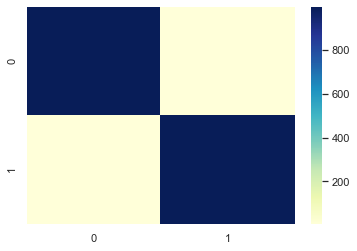

In [40]:
print('Confusion Matrix:')
sns.heatmap(confusion_matrix(y_test, y_knn_pred), cmap='YlGnBu')
plt.show()

In [41]:
print('Classification Report:')
print(classification_report(y_test, y_knn_pred, target_names=['-ve', '+ve']))

Classification Report:
              precision    recall  f1-score   support

         -ve       0.99      0.99      0.99      1000
         +ve       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [42]:
acc_knn = accuracy_score(y_test, y_knn_pred) * 100
print(f'Accuracy: {acc_knn:2.2f}%')

Accuracy: 99.45%


# Result

As far as model performance metrics are concerned, we can plot the model accuracies in a bar plot and determine which model performed the best on the dataset and our way of feature extraction.

/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


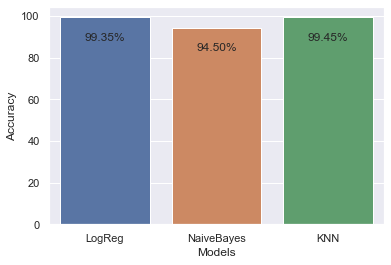

In [43]:
ax = sns.barplot(['LogReg', 'NaiveBayes', 'KNN'], [acc_logReg, acc_nb, acc_knn])
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():2.2f}%', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', va = 'center', 
        xytext = (0, -20), textcoords = 'offset points'
    )
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()

# Conclusion

The KNN Model with hyperparameter `k = 4` performed best in classifying the sentiments of the tweets.

In [44]:
import joblib
joblib.dump(knnModel, 'model.pkl')
knn_from_pickle = joblib.load('model.pkl')
knn_from_pickle.predict(x_knn_test)

array([1., 1., 1., ..., 0., 0., 0.])